# 🧠 Treinamento de Modelos CNN - Detecção de Pneumonia

Neste notebook, vamos treinar diferentes arquiteturas de redes neurais convolucionais (CNN) para detectar pneumonia em radiografias de tórax.

## 📋 Objetivos:
1. Preparar dados com data augmentation
2. Treinar modelo CNN simples (baseline)
3. Treinar modelos com Transfer Learning (VGG16, ResNet50)
4. Avaliar e comparar todos os modelos
5. Interpretar resultados

---

## 📚 1. Importar Bibliotecas e Módulos

## ⚙️ Configuração de GPU (Importante!)

**Status da GPU:**
- Este notebook pode rodar com ou sem GPU
- **Com GPU**: Treinamento 10-15x mais rápido (~30-60 minutos total)
- **Sem GPU (CPU)**: Treinamento mais lento (~2-4 horas total)

**Ambiente Recomendado (seguindo documentação oficial TensorFlow):**
- **Python 3.9**
- **TensorFlow 2.10**
- **CUDA 11.2** + **cuDNN 8.1** (instalados via conda)

**Se você tem GPU NVIDIA mas ela não está sendo detectada:**

Siga a documentação oficial: https://www.tensorflow.org/install/pip?hl=pt-br#windows-native

Usando Conda (recomendado):
```bash
conda create -n venv python=3.9 -y
conda activate venv
conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0 -y
pip install "tensorflow<2.11"
```

**Ajustes para rodar sem GPU:**
```python
# Reduzir batch size e epochs se for usar CPU
BATCH_SIZE = 16  # ao invés de 32
EPOCHS = 10      # ao invés de 20
```

In [1]:
# Adicionar diretório src ao path
import sys
from pathlib import Path
sys.path.append(str(Path('..').resolve()))

# Importar módulos customizados
from src.preprocessing import (
    create_data_generators, 
    analyze_dataset_distribution,
    get_class_weights,
    visualize_samples
)
from src.models import (
    create_simple_cnn,
    create_vgg16_transfer,
    create_resnet50_transfer,
    print_model_summary
)
from src.evaluation import (
    evaluate_model,
    plot_confusion_matrix,
    plot_roc_curve,
    plot_training_history,
    compare_models_results
)

# Bibliotecas padrão
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Configurações
import warnings
warnings.filterwarnings('ignore')

# Seed para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Bibliotecas importadas!")
print(f"🔧 TensorFlow version: {tf.__version__}")

# Verificar GPU
gpus = tf.config.list_physical_devices('GPU')
gpu_available = len(gpus) > 0

if gpu_available:
    print(f"🎮 GPU disponível: SIM - {len(gpus)} dispositivo(s)")
    for i, gpu in enumerate(gpus):
        print(f"   GPU {i}: {gpu}")
    print("⚡ Treinamento será RÁPIDO!")
else:
    print("💻 GPU disponível: NÃO - Usando CPU")
    print("⏳ Treinamento será mais lento (considere reduzir BATCH_SIZE e EPOCHS)")
    print("\n💡 Para habilitar GPU:")
    print("   1. Verifique se tem NVIDIA GPU")
    print("   2. Instale CUDA 12.6 (não 13.0): https://developer.nvidia.com/cuda-12-6-0-download-archive")
    print("   3. Instale cuDNN 9.x para CUDA 12.6")
    print("   4. Reinicie o notebook")

✅ Bibliotecas importadas!
🔧 TensorFlow version: 2.10.1
🎮 GPU disponível: SIM - 1 dispositivo(s)
   GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
⚡ Treinamento será RÁPIDO!


## 📂 2. Configurar Caminhos e Parâmetros

In [2]:
# Caminhos
BASE_DIR = Path('..')
DATA_DIR = BASE_DIR / 'data' / 'chest_xray'
RESULTS_DIR = BASE_DIR / 'results'
MODELS_DIR = RESULTS_DIR / 'modelos'
GRAFICOS_DIR = RESULTS_DIR / 'graficos'

# Criar diretórios se não existirem
MODELS_DIR.mkdir(parents=True, exist_ok=True)
GRAFICOS_DIR.mkdir(parents=True, exist_ok=True)

# Parâmetros de treinamento
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20  # Ajuste conforme necessário
PATIENCE = 5  # Para early stopping

print("✅ Configurações definidas!")
print(f"📁 Dados: {DATA_DIR}")
print(f"💾 Modelos serão salvos em: {MODELS_DIR}")
print(f"📊 Gráficos serão salvos em: {GRAFICOS_DIR}")

✅ Configurações definidas!
📁 Dados: ..\data\chest_xray
💾 Modelos serão salvos em: ..\results\modelos
📊 Gráficos serão salvos em: ..\results\graficos


## 📊 3. Análise e Preparação dos Dados

In [3]:
# Analisar distribuição do dataset
print("📊 Análise do dataset:\n")
stats = analyze_dataset_distribution(DATA_DIR)

📊 Análise do dataset:

📊 Distribuição do Dataset


TRAIN:
  Normal:     1341 (25.7%)
  Pneumonia:  3875 (74.3%)
  Total:      5216

TEST:
  Normal:      234 (37.5%)
  Pneumonia:   390 (62.5%)
  Total:       624

VAL:
  Normal:        8 (50.0%)
  Pneumonia:     8 (50.0%)
  Total:        16



### 🔄 Criar Geradores de Dados

In [4]:
# Criar geradores COM data augmentation
print("\n🔄 Criando geradores de dados com Data Augmentation...\n")

train_generator, val_generator, test_generator = create_data_generators(
    DATA_DIR,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    augmentation=True,
    validation_split=0.2
)

print(f"✅ Gerador de treino: {train_generator.samples} amostras")
print(f"✅ Gerador de validação: {val_generator.samples} amostras")
print(f"✅ Gerador de teste: {test_generator.samples} amostras")

# Verificar classes
print(f"\n🏷️ Classes: {train_generator.class_indices}")


🔄 Criando geradores de dados com Data Augmentation...

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
✅ Gerador de treino: 4173 amostras
✅ Gerador de validação: 1043 amostras
✅ Gerador de teste: 624 amostras

🏷️ Classes: {'NORMAL': 0, 'PNEUMONIA': 1}
Found 624 images belonging to 2 classes.
✅ Gerador de treino: 4173 amostras
✅ Gerador de validação: 1043 amostras
✅ Gerador de teste: 624 amostras

🏷️ Classes: {'NORMAL': 0, 'PNEUMONIA': 1}


### 📸 Visualizar Amostras com Augmentation


📸 Visualizando amostras de treino (com data augmentation)...




📸 Visualizando amostras de treino (com data augmentation)...



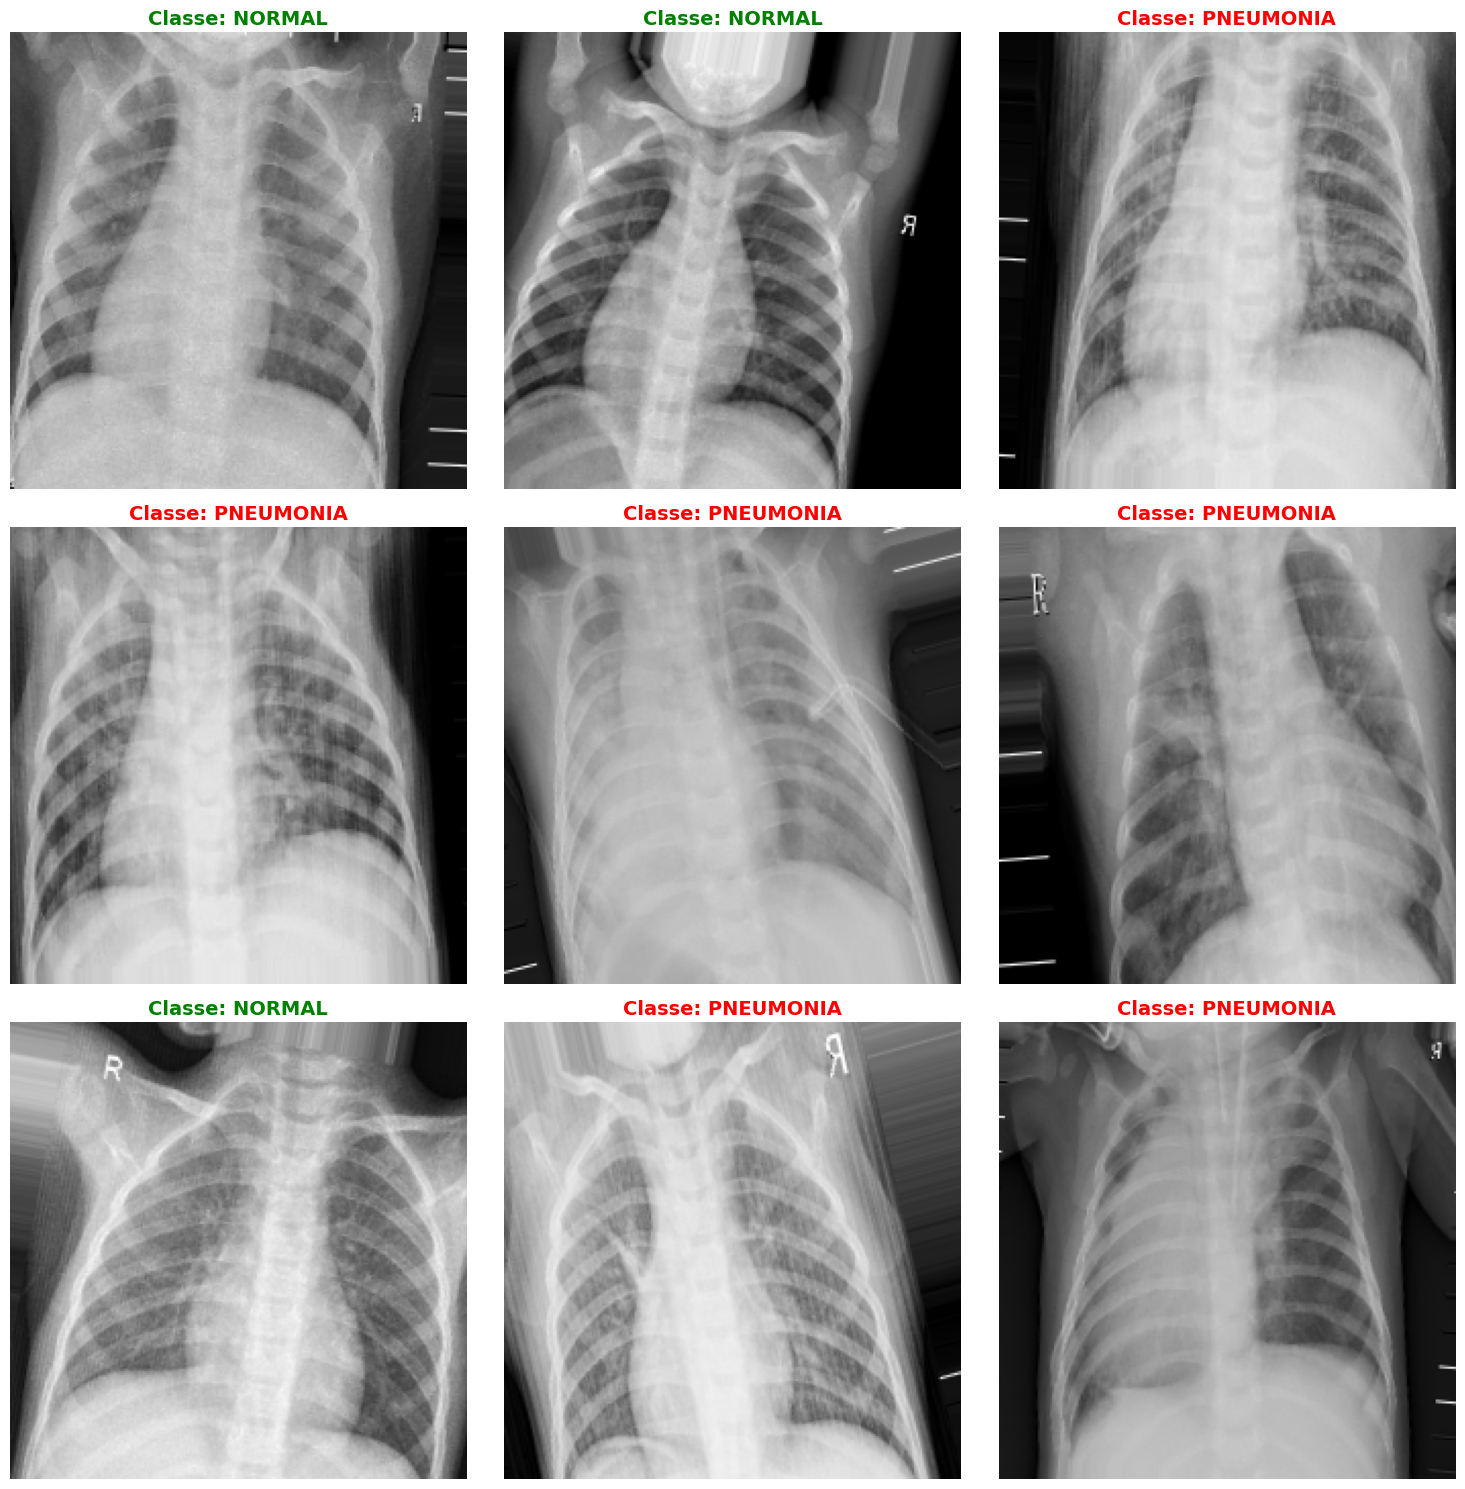

In [5]:
# Visualizar algumas amostras
print("\n📸 Visualizando amostras de treino (com data augmentation)...\n")
visualize_samples(train_generator, num_samples=9)

### ⚖️ Calcular Pesos das Classes

In [6]:
# Calcular class weights para lidar com desbalanceamento
class_weights = get_class_weights(train_generator)

print("\n💡 Esses pesos ajudam o modelo a dar mais atenção à classe minoritária!")


⚖️ Pesos das Classes (para balanceamento):
  Classe 0 (NORMAL):    1.94
  Classe 1 (PNEUMONIA): 0.67

💡 Esses pesos ajudam o modelo a dar mais atenção à classe minoritária!


## 🎛️ 4. Definir Callbacks

In [7]:
def get_callbacks(model_name):
    """Retorna callbacks para treinamento."""
    
    callbacks = [
        # Early Stopping: para se não houver melhora
        EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            verbose=1,
            restore_best_weights=True
        ),
        
        # Model Checkpoint: salva melhor modelo
        ModelCheckpoint(
            filepath=str(MODELS_DIR / f'{model_name}_best.h5'),
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        
        # Reduce Learning Rate: reduz LR quando estagnado
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1,
            min_lr=1e-7
        )
    ]
    
    return callbacks

print("✅ Callbacks configurados!")
print("   - Early Stopping (paciência: 5 épocas)")
print("   - Model Checkpoint (salva melhor modelo)")
print("   - Reduce LR on Plateau (reduz learning rate)")

✅ Callbacks configurados!
   - Early Stopping (paciência: 5 épocas)
   - Model Checkpoint (salva melhor modelo)
   - Reduce LR on Plateau (reduz learning rate)


---
# 🚀 TREINAMENTO DOS MODELOS
---

## 1️⃣ Modelo 1: CNN Simples (Baseline)

Este é nosso modelo baseline - uma CNN simples criada do zero. Serve para termos uma referência de desempenho.

In [8]:
print("="*70)
print("🔧 MODELO 1: CNN SIMPLES (BASELINE)")
print("="*70)

# Criar modelo
model_cnn = create_simple_cnn(input_shape=(*IMG_SIZE, 3), dropout_rate=0.5)

# Ver arquitetura
print_model_summary(model_cnn, "CNN Simples")

🔧 MODELO 1: CNN SIMPLES (BASELINE)

📊 Resumo do CNN Simples

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                         

In [9]:
# Treinar modelo
print("\n🚀 Iniciando treinamento da CNN Simples...\n")

history_cnn = model_cnn.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=get_callbacks('cnn_simple'),
    verbose=1
)

print("\n✅ Treinamento da CNN Simples concluído!")


🚀 Iniciando treinamento da CNN Simples...

Epoch 1/20
Epoch 1/20
131/131 [==============================] - ETA: 0s - loss: 1.2289 - accuracy: 0.8347 - precision: 0.9316 - recall: 0.8390 - auc: 0.8868
Epoch 1: val_loss improved from inf to 11.36341, saving model to ..\results\modelos\cnn_simple_best.h5

Epoch 1: val_loss improved from inf to 11.36341, saving model to ..\results\modelos\cnn_simple_best.h5
131/131 [==============================] - 587s 479ms/step - loss: 1.2289 - accuracy: 0.8347 - precision: 0.9316 - recall: 0.8390 - auc: 0.8868 - val_loss: 11.3634 - val_accuracy: 0.7430 - val_precision: 0.7430 - val_recall: 1.0000 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/20
131/131 [==============================] - 587s 479ms/step - loss: 1.2289 - accuracy: 0.8347 - precision: 0.9316 - recall: 0.8390 - auc: 0.8868 - val_loss: 11.3634 - val_accuracy: 0.7430 - val_precision: 0.7430 - val_recall: 1.0000 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/20
131/131 [==============================] - 


📈 Visualizando histórico de treinamento...

✅ Figura salva em: ..\results\graficos\cnn_simple_history.png
✅ Figura salva em: ..\results\graficos\cnn_simple_history.png



📈 Visualizando histórico de treinamento...

✅ Figura salva em: ..\results\graficos\cnn_simple_history.png
✅ Figura salva em: ..\results\graficos\cnn_simple_history.png


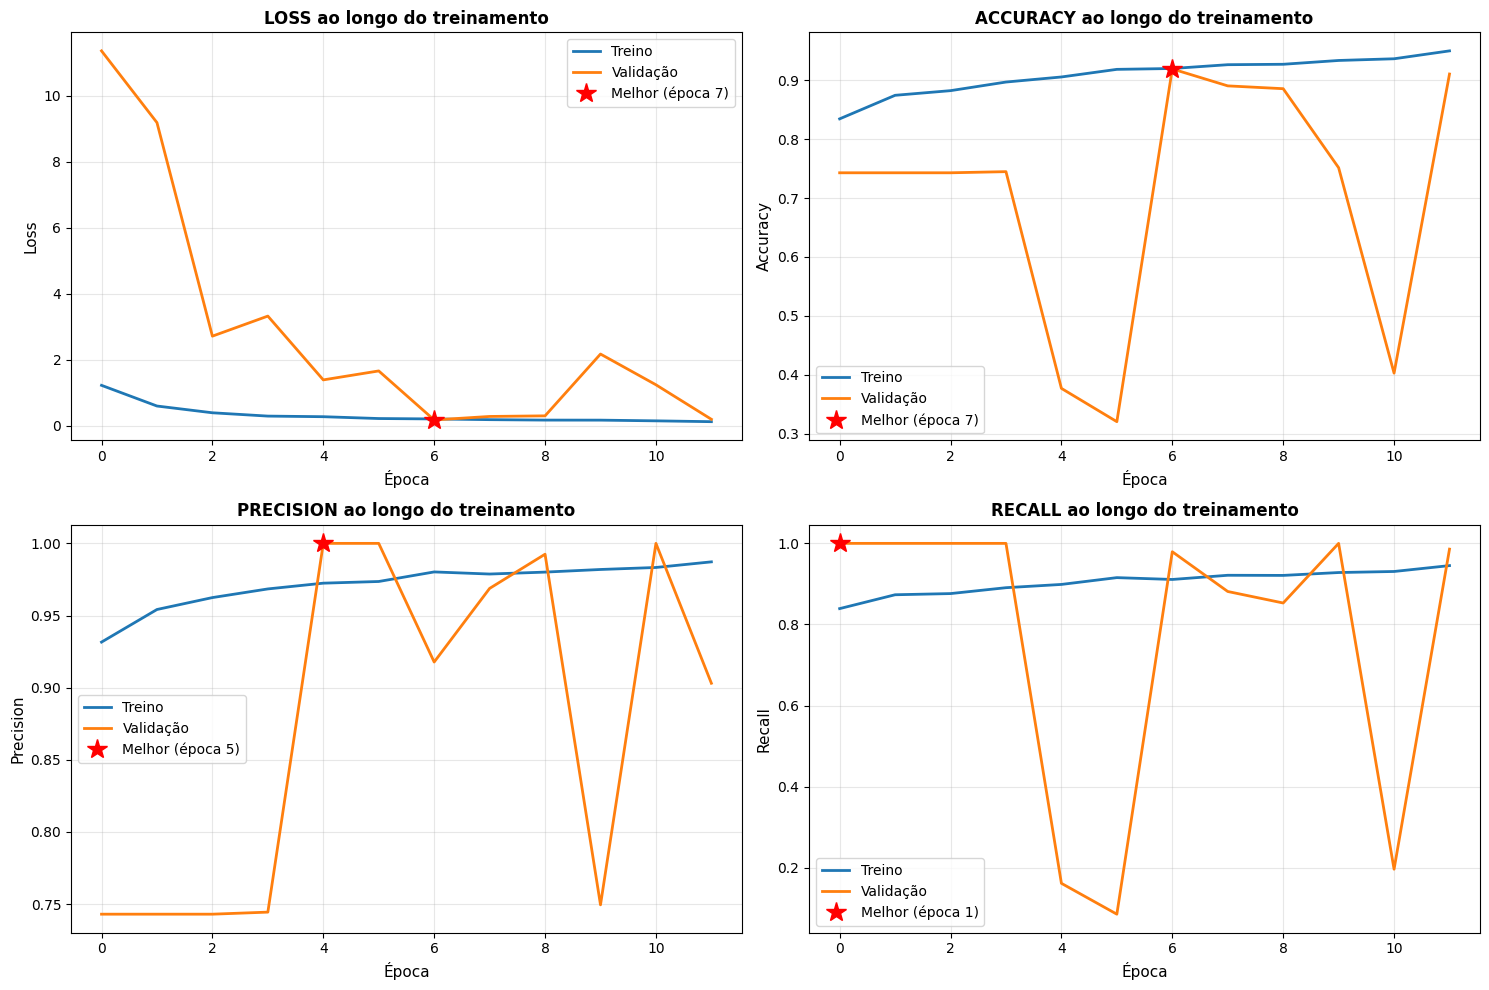

In [11]:
# Plotar histórico de treinamento
print("\n📈 Visualizando histórico de treinamento...\n")
plot_training_history(history_cnn, save_path=GRAFICOS_DIR / 'cnn_simple_history.png')

In [14]:
# Avaliar no conjunto de teste
print("\n📊 Avaliando CNN Simples no conjunto de teste...\n")
results_cnn = evaluate_model(model_cnn, test_generator)


📊 Avaliando CNN Simples no conjunto de teste...

🔍 Avaliando modelo no conjunto de teste...

20/20 [==============================] - 2s 112ms/step

📊 Métricas Gerais:
Accuracy:  0.7917 (79.17%)
F1-Score:  0.8562
AUC-ROC:   0.9538

📋 Relatório Detalhado por Classe:

              precision    recall  f1-score   support

      NORMAL     0.9727    0.4573    0.6221       234
   PNEUMONIA     0.7529    0.9923    0.8562       390

    accuracy                         0.7917       624
   macro avg     0.8628    0.7248    0.7391       624
weighted avg     0.8353    0.7917    0.7684       624



✅ Figura salva em: ..\results\graficos\cnn_simple_confusion_matrix.png


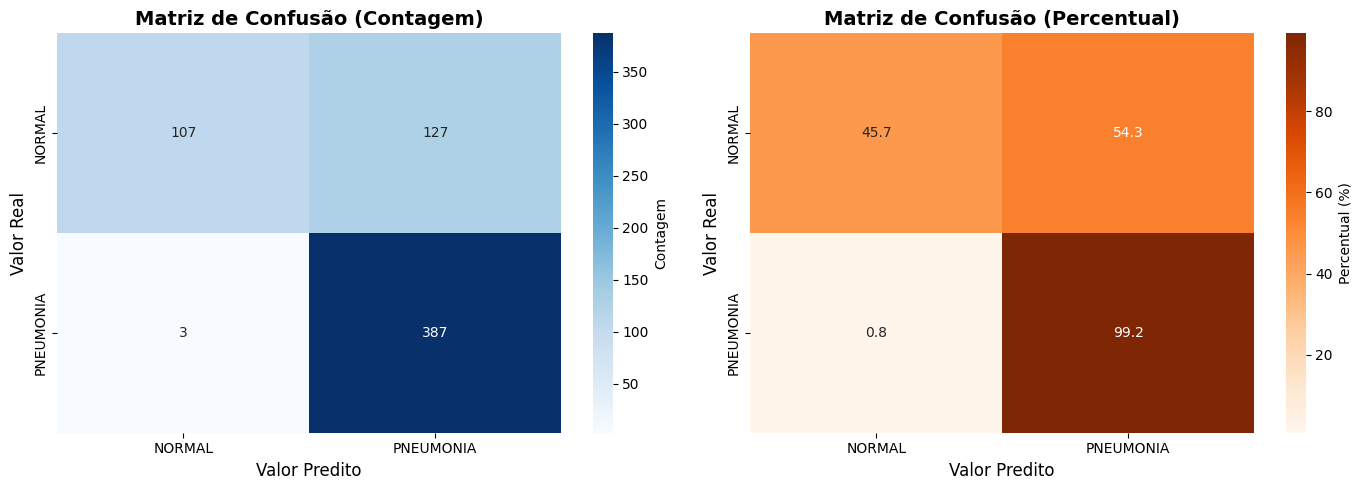


📊 Análise da Matriz de Confusão:
Verdadeiros Negativos (TN):  107  - Correto: NORMAL como NORMAL
Falsos Positivos (FP):       127  - Erro: NORMAL como PNEUMONIA
Falsos Negativos (FN):         3  - Erro: PNEUMONIA como NORMAL ⚠️
Verdadeiros Positivos (TP):  387  - Correto: PNEUMONIA como PNEUMONIA

⚠️ IMPORTANTE: Falsos Negativos são críticos em medicina!
   Não detectar uma pneumonia real pode ter consequências graves.



In [15]:
# Plotar matriz de confusão
plot_confusion_matrix(
    results_cnn['y_true'], 
    results_cnn['predictions'],
    save_path=GRAFICOS_DIR / 'cnn_simple_confusion_matrix.png'
)

✅ Figura salva em: ..\results\graficos\cnn_simple_roc_curve.png


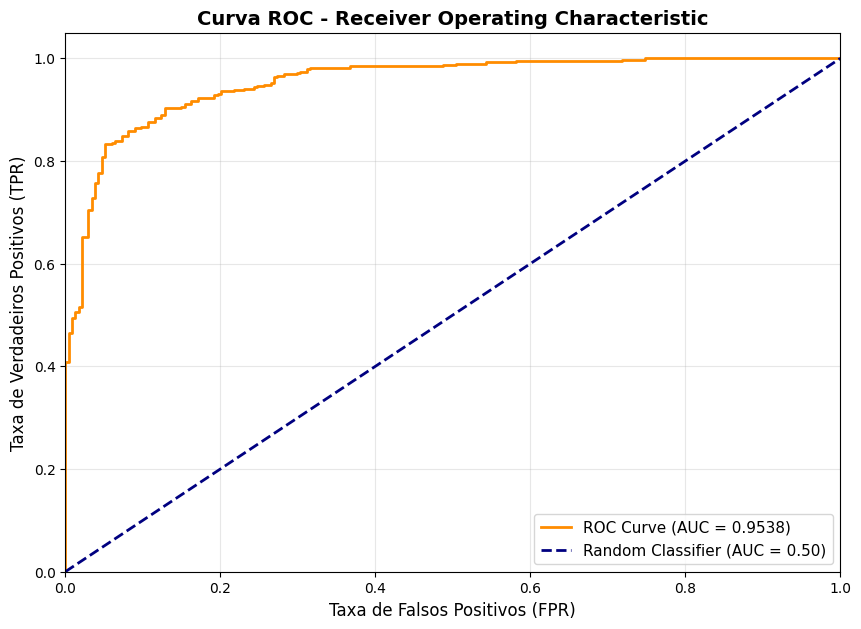


📈 Interpretação da Curva ROC:
AUC = 0.9538
   Excelente capacidade de discriminação! 🌟



In [16]:
# Plotar curva ROC
plot_roc_curve(
    results_cnn['y_true'], 
    results_cnn['predictions_prob'],
    save_path=GRAFICOS_DIR / 'cnn_simple_roc_curve.png'
)

## 2️⃣ Modelo 2: VGG16 Transfer Learning

Agora vamos usar Transfer Learning com VGG16, um modelo já treinado no ImageNet. Isso geralmente dá melhores resultados!

In [17]:
print("\n" + "="*70)
print("🔧 MODELO 2: VGG16 TRANSFER LEARNING")
print("="*70)

# Criar modelo
model_vgg16 = create_vgg16_transfer(input_shape=(*IMG_SIZE, 3), trainable_layers=4)

# Ver arquitetura
print_model_summary(model_vgg16, "VGG16 Transfer Learning")


🔧 MODELO 2: VGG16 TRANSFER LEARNING
58889256/58889256 [==============================] - 3s 0us/step

📊 Resumo do VGG16 Transfer Learning

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                              

In [18]:
# Treinar modelo
print("\n🚀 Iniciando treinamento do VGG16...\n")
print("💡 Este modelo pode demorar mais, mas geralmente tem melhor desempenho!\n")

history_vgg16 = model_vgg16.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=get_callbacks('vgg16_transfer'),
    verbose=1
)

print("\n✅ Treinamento do VGG16 concluído!")


🚀 Iniciando treinamento do VGG16...

💡 Este modelo pode demorar mais, mas geralmente tem melhor desempenho!

Epoch 1/20
Epoch 1/20
131/131 [==============================] - ETA: 0s - loss: 0.7916 - accuracy: 0.5080 - precision: 0.7407 - recall: 0.5197 - auc: 0.4980
Epoch 1: val_loss improved from inf to 0.75180, saving model to ..\results\modelos\vgg16_transfer_best.h5

Epoch 1: val_loss improved from inf to 0.75180, saving model to ..\results\modelos\vgg16_transfer_best.h5
131/131 [==============================] - 50s 362ms/step - loss: 0.7916 - accuracy: 0.5080 - precision: 0.7407 - recall: 0.5197 - auc: 0.4980 - val_loss: 0.7518 - val_accuracy: 0.2752 - val_precision: 1.0000 - val_recall: 0.0245 - val_auc: 0.5799 - lr: 1.0000e-04
Epoch 2/20
Epoch 2/20
131/131 [==============================] - ETA: 0s - loss: 0.7928 - accuracy: 0.4941 - precision: 0.7442 - recall: 0.4861 - auc: 0.4982
Epoch 2: val_loss improved from 0.75180 to 0.71887, saving model to ..\results\modelos\vgg16_tra


📈 Visualizando histórico de treinamento...

✅ Figura salva em: ..\results\graficos\vgg16_history.png
✅ Figura salva em: ..\results\graficos\vgg16_history.png


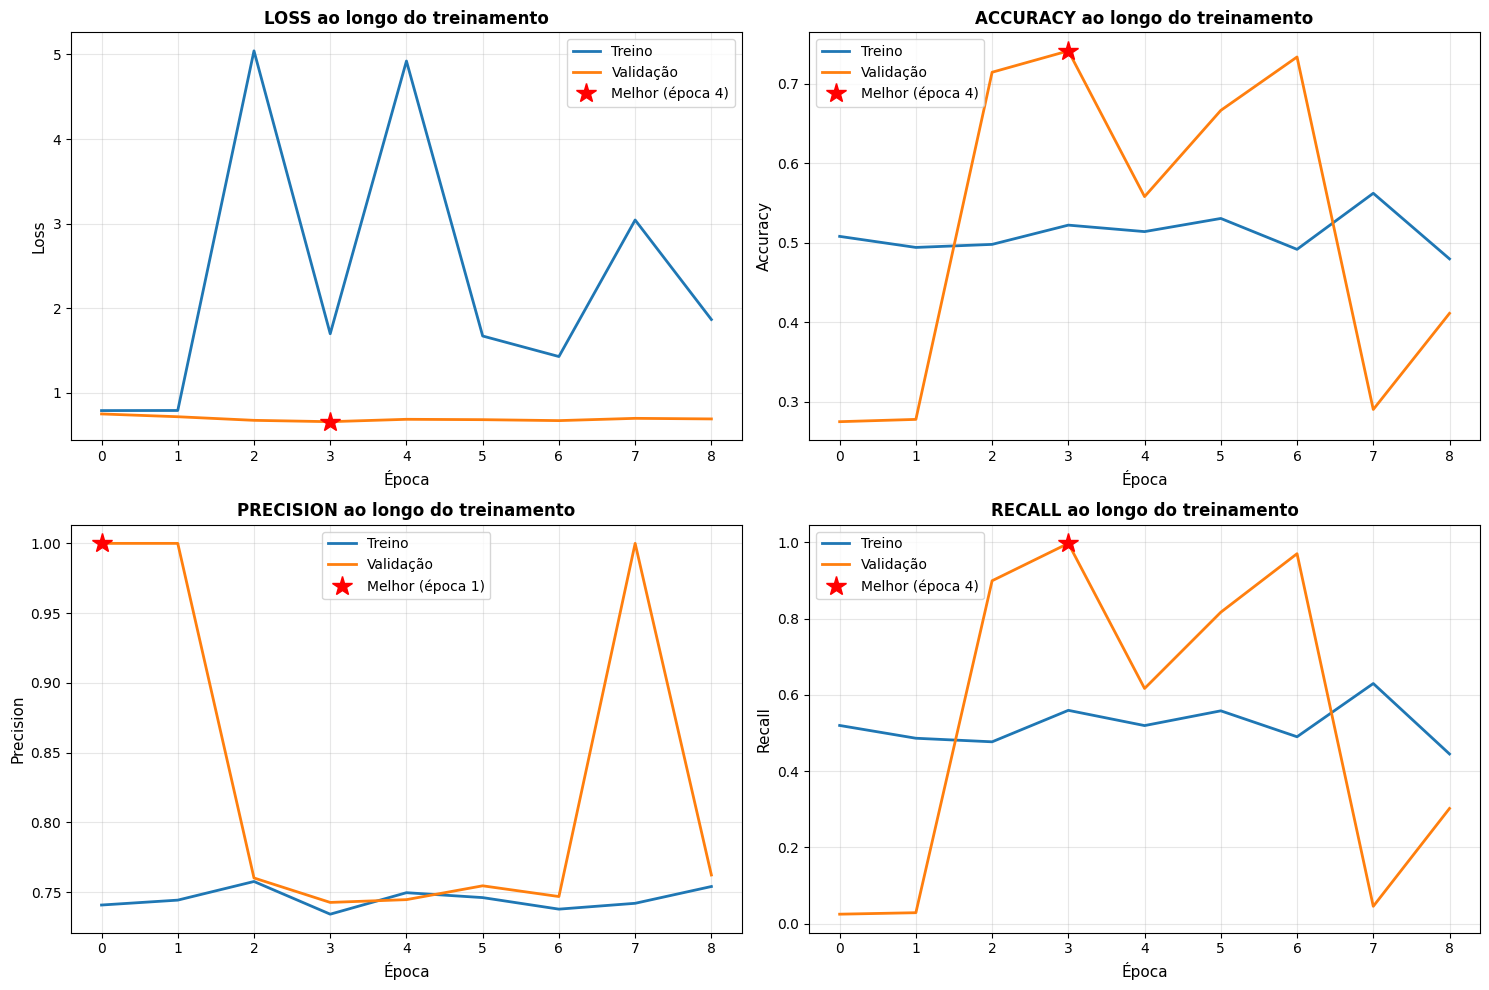

In [19]:
# Plotar histórico
print("\n📈 Visualizando histórico de treinamento...\n")
plot_training_history(history_vgg16, save_path=GRAFICOS_DIR / 'vgg16_history.png')

In [20]:
# Avaliar no conjunto de teste
print("\n📊 Avaliando VGG16 no conjunto de teste...\n")
results_vgg16 = evaluate_model(model_vgg16, test_generator)


📊 Avaliando VGG16 no conjunto de teste...

🔍 Avaliando modelo no conjunto de teste...

20/20 [==============================] - 4s 168ms/step

📊 Métricas Gerais:
Accuracy:  0.6250 (62.50%)
F1-Score:  0.7692
AUC-ROC:   0.6141

📋 Relatório Detalhado por Classe:

              precision    recall  f1-score   support

      NORMAL     0.0000    0.0000    0.0000       234
   PNEUMONIA     0.6250    1.0000    0.7692       390

    accuracy                         0.6250       624
   macro avg     0.3125    0.5000    0.3846       624
weighted avg     0.3906    0.6250    0.4808       624

20/20 [==============================] - 4s 168ms/step

📊 Métricas Gerais:
Accuracy:  0.6250 (62.50%)
F1-Score:  0.7692
AUC-ROC:   0.6141

📋 Relatório Detalhado por Classe:

              precision    recall  f1-score   support

      NORMAL     0.0000    0.0000    0.0000       234
   PNEUMONIA     0.6250    1.0000    0.7692       390

    accuracy                         0.6250       624
   macro avg     0.

✅ Figura salva em: ..\results\graficos\vgg16_confusion_matrix.png


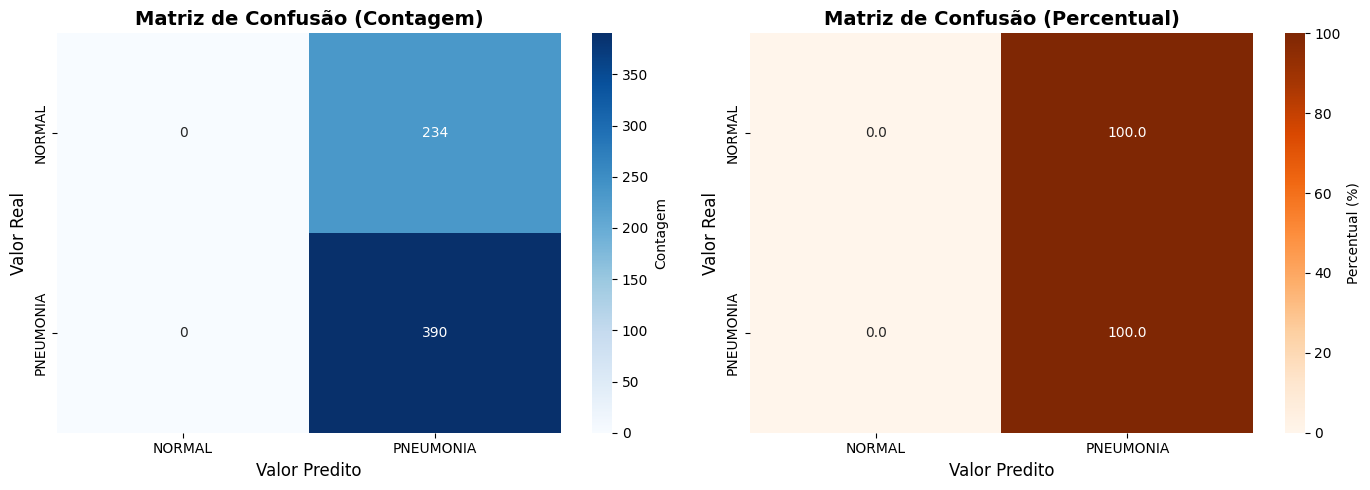


📊 Análise da Matriz de Confusão:
Verdadeiros Negativos (TN):    0  - Correto: NORMAL como NORMAL
Falsos Positivos (FP):       234  - Erro: NORMAL como PNEUMONIA
Falsos Negativos (FN):         0  - Erro: PNEUMONIA como NORMAL ⚠️
Verdadeiros Positivos (TP):  390  - Correto: PNEUMONIA como PNEUMONIA

⚠️ IMPORTANTE: Falsos Negativos são críticos em medicina!
   Não detectar uma pneumonia real pode ter consequências graves.



In [21]:
# Plotar matriz de confusão
plot_confusion_matrix(
    results_vgg16['y_true'], 
    results_vgg16['predictions'],
    save_path=GRAFICOS_DIR / 'vgg16_confusion_matrix.png'
)

✅ Figura salva em: ..\results\graficos\vgg16_roc_curve.png


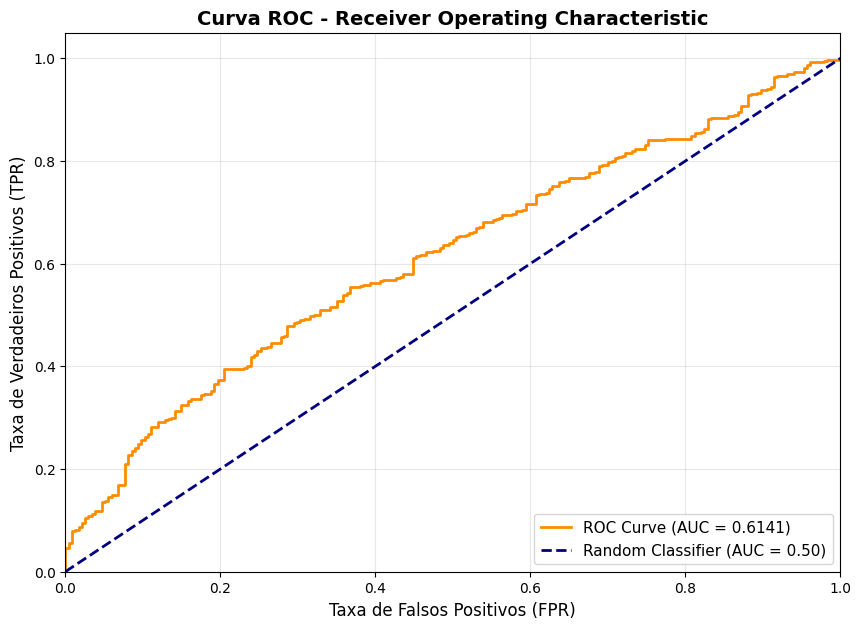


📈 Interpretação da Curva ROC:
AUC = 0.6141
   Capacidade limitada de discriminação. ⚠️



In [22]:
# Plotar curva ROC
plot_roc_curve(
    results_vgg16['y_true'], 
    results_vgg16['predictions_prob'],
    save_path=GRAFICOS_DIR / 'vgg16_roc_curve.png'
)

## 3️⃣ Modelo 3: ResNet50 Transfer Learning

Por último, vamos treinar com ResNet50, uma arquitetura mais moderna que geralmente supera a VGG16!

In [23]:
print("\n" + "="*70)
print("🔧 MODELO 3: RESNET50 TRANSFER LEARNING")
print("="*70)

# Criar modelo
model_resnet50 = create_resnet50_transfer(input_shape=(*IMG_SIZE, 3), trainable_layers=10)

# Ver arquitetura
print_model_summary(model_resnet50, "ResNet50 Transfer Learning")


🔧 MODELO 3: RESNET50 TRANSFER LEARNING
94765736/94765736 [==============================] - 4s 0us/step

📊 Resumo do ResNet50 Transfer Learning

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 512)

In [24]:
# Treinar modelo
print("\n🚀 Iniciando treinamento do ResNet50...\n")
print("💡 ResNet50 usa conexões residuais - uma arquitetura mais moderna!\n")

history_resnet50 = model_resnet50.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=get_callbacks('resnet50_transfer'),
    verbose=1
)

print("\n✅ Treinamento do ResNet50 concluído!")


🚀 Iniciando treinamento do ResNet50...

💡 ResNet50 usa conexões residuais - uma arquitetura mais moderna!

Epoch 1/20
Epoch 1/20
131/131 [==============================] - ETA: 0s - loss: 0.4379 - accuracy: 0.7956 - precision: 0.9584 - recall: 0.7577 - auc: 0.9090
Epoch 1: val_loss improved from inf to 0.74153, saving model to ..\results\modelos\resnet50_transfer_best.h5

Epoch 1: val_loss improved from inf to 0.74153, saving model to ..\results\modelos\resnet50_transfer_best.h5
131/131 [==============================] - 47s 338ms/step - loss: 0.4379 - accuracy: 0.7956 - precision: 0.9584 - recall: 0.7577 - auc: 0.9090 - val_loss: 0.7415 - val_accuracy: 0.2570 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9108 - lr: 1.0000e-04
Epoch 2/20
Epoch 2/20
131/131 [==============================] - ETA: 0s - loss: 0.3473 - accuracy: 0.8533 - precision: 0.9726 - recall: 0.8258 - auc: 0.9421
Epoch 2: val_loss improved from 0.74153 to 0.51290, saving model to ..\results\model


📈 Visualizando histórico de treinamento...

✅ Figura salva em: ..\results\graficos\resnet50_history.png
✅ Figura salva em: ..\results\graficos\resnet50_history.png


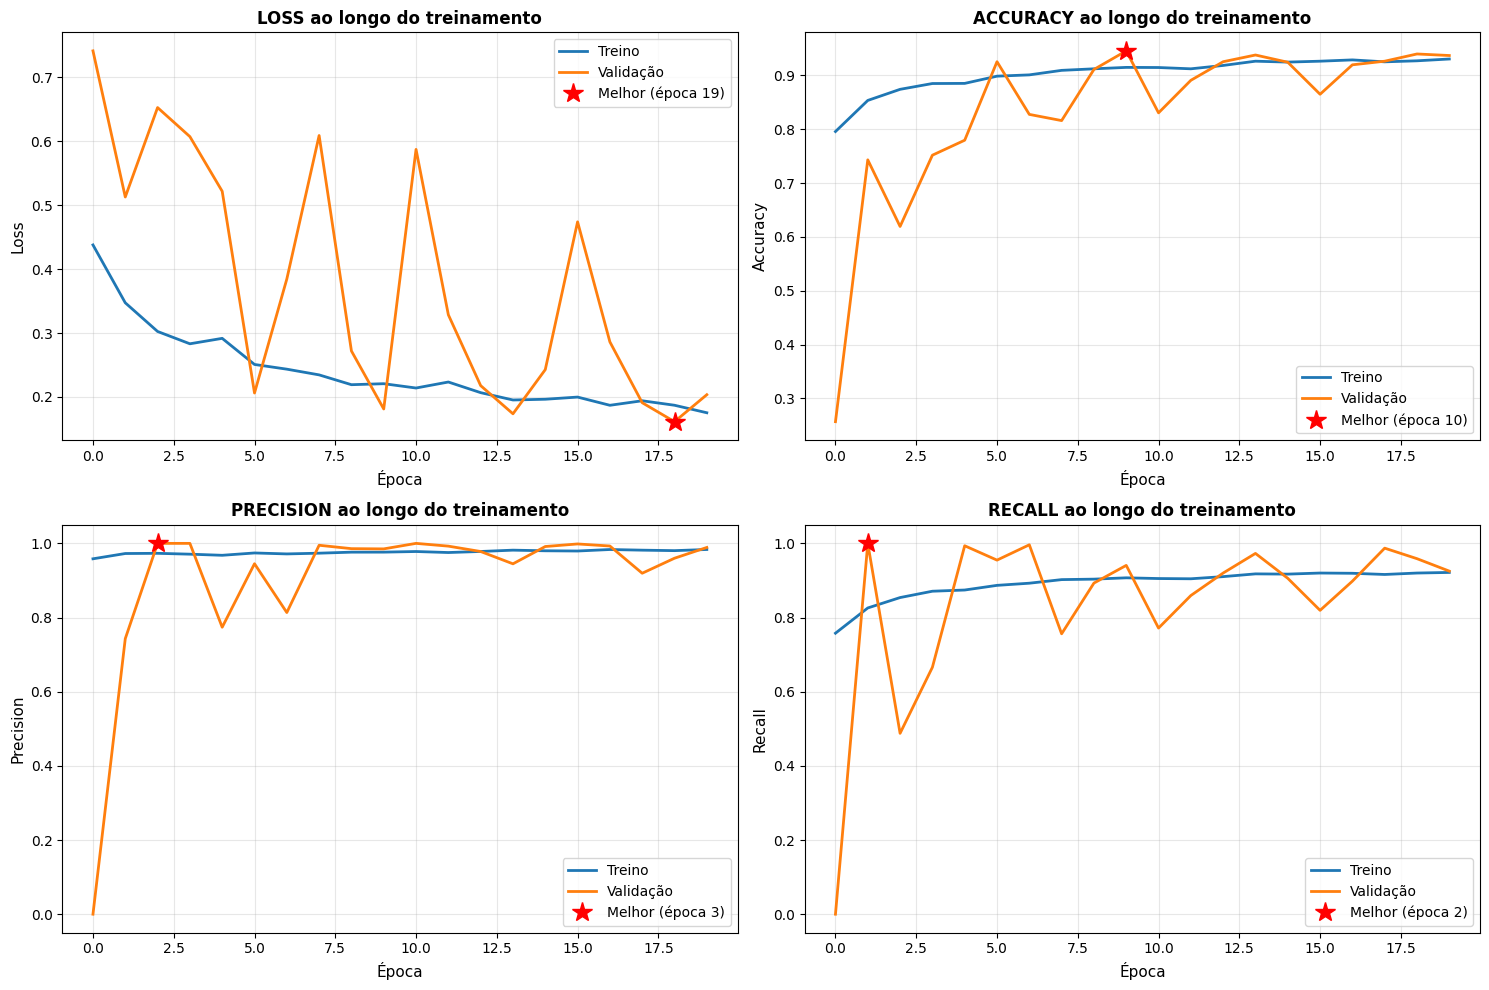

In [25]:
# Plotar histórico
print("\n📈 Visualizando histórico de treinamento...\n")
plot_training_history(history_resnet50, save_path=GRAFICOS_DIR / 'resnet50_history.png')

In [26]:
# Avaliar no conjunto de teste
print("\n📊 Avaliando ResNet50 no conjunto de teste...\n")
results_resnet50 = evaluate_model(model_resnet50, test_generator)


📊 Avaliando ResNet50 no conjunto de teste...

🔍 Avaliando modelo no conjunto de teste...

20/20 [==============================] - 3s 117ms/step

📊 Métricas Gerais:
Accuracy:  0.8782 (87.82%)
F1-Score:  0.9045
AUC-ROC:   0.9296

📋 Relatório Detalhado por Classe:

              precision    recall  f1-score   support

      NORMAL     0.8624    0.8034    0.8319       234
   PNEUMONIA     0.8867    0.9231    0.9045       390

    accuracy                         0.8782       624
   macro avg     0.8745    0.8632    0.8682       624
weighted avg     0.8776    0.8782    0.8773       624


📊 Métricas Gerais:
Accuracy:  0.8782 (87.82%)
F1-Score:  0.9045
AUC-ROC:   0.9296

📋 Relatório Detalhado por Classe:

              precision    recall  f1-score   support

      NORMAL     0.8624    0.8034    0.8319       234
   PNEUMONIA     0.8867    0.9231    0.9045       390

    accuracy                         0.8782       624
   macro avg     0.8745    0.8632    0.8682       624
weighted avg     

✅ Figura salva em: ..\results\graficos\resnet50_confusion_matrix.png


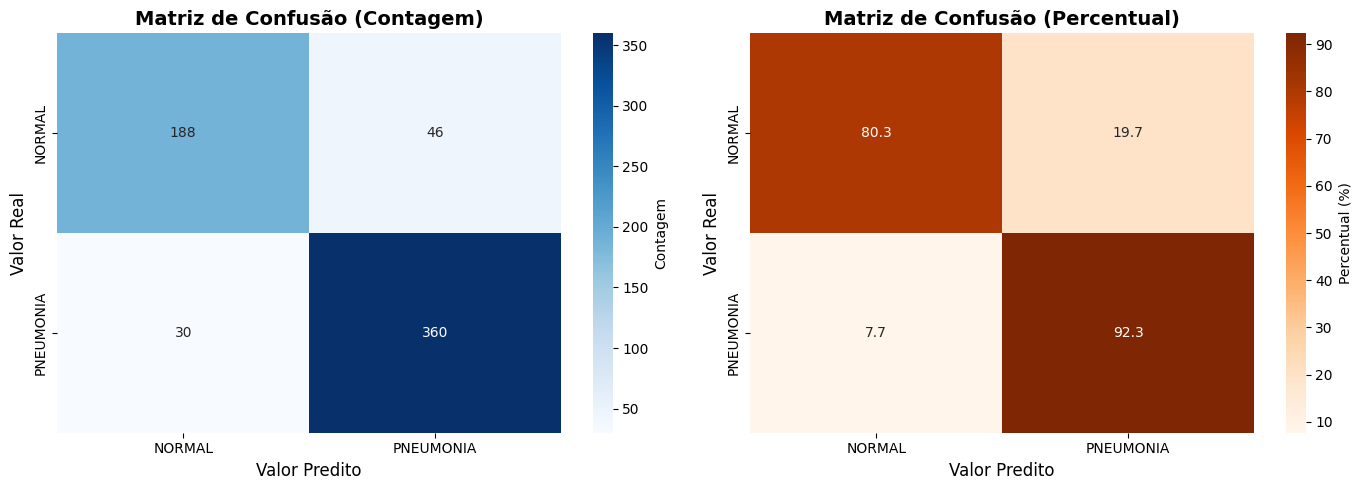


📊 Análise da Matriz de Confusão:
Verdadeiros Negativos (TN):  188  - Correto: NORMAL como NORMAL
Falsos Positivos (FP):        46  - Erro: NORMAL como PNEUMONIA
Falsos Negativos (FN):        30  - Erro: PNEUMONIA como NORMAL ⚠️
Verdadeiros Positivos (TP):  360  - Correto: PNEUMONIA como PNEUMONIA

⚠️ IMPORTANTE: Falsos Negativos são críticos em medicina!
   Não detectar uma pneumonia real pode ter consequências graves.



In [27]:
# Plotar matriz de confusão
plot_confusion_matrix(
    results_resnet50['y_true'], 
    results_resnet50['predictions'],
    save_path=GRAFICOS_DIR / 'resnet50_confusion_matrix.png'
)

✅ Figura salva em: ..\results\graficos\resnet50_roc_curve.png


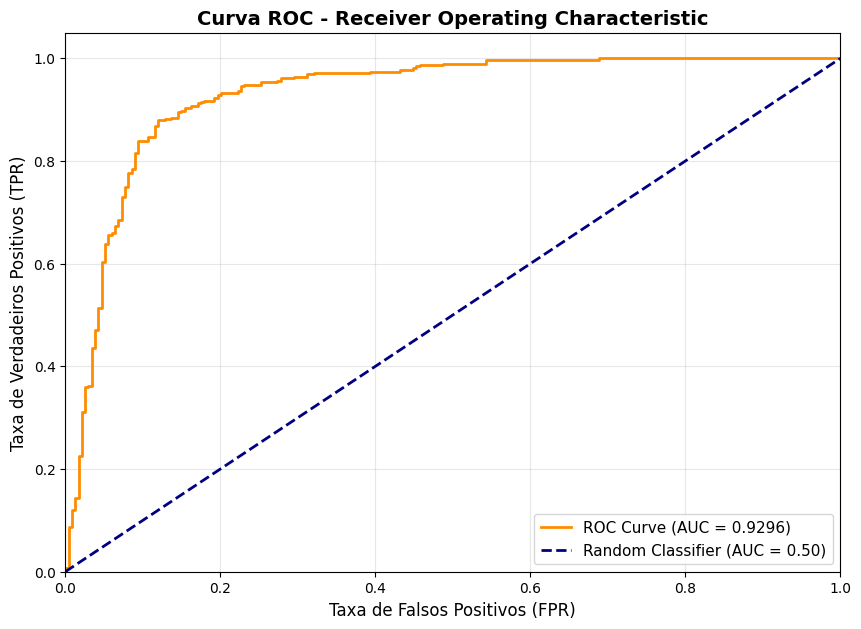


📈 Interpretação da Curva ROC:
AUC = 0.9296
   Excelente capacidade de discriminação! 🌟



In [28]:
# Plotar curva ROC
plot_roc_curve(
    results_resnet50['y_true'], 
    results_resnet50['predictions_prob'],
    save_path=GRAFICOS_DIR / 'resnet50_roc_curve.png'
)

---
# 📊 COMPARAÇÃO FINAL DOS MODELOS
---


🏆 COMPARAÇÃO DE TODOS OS MODELOS



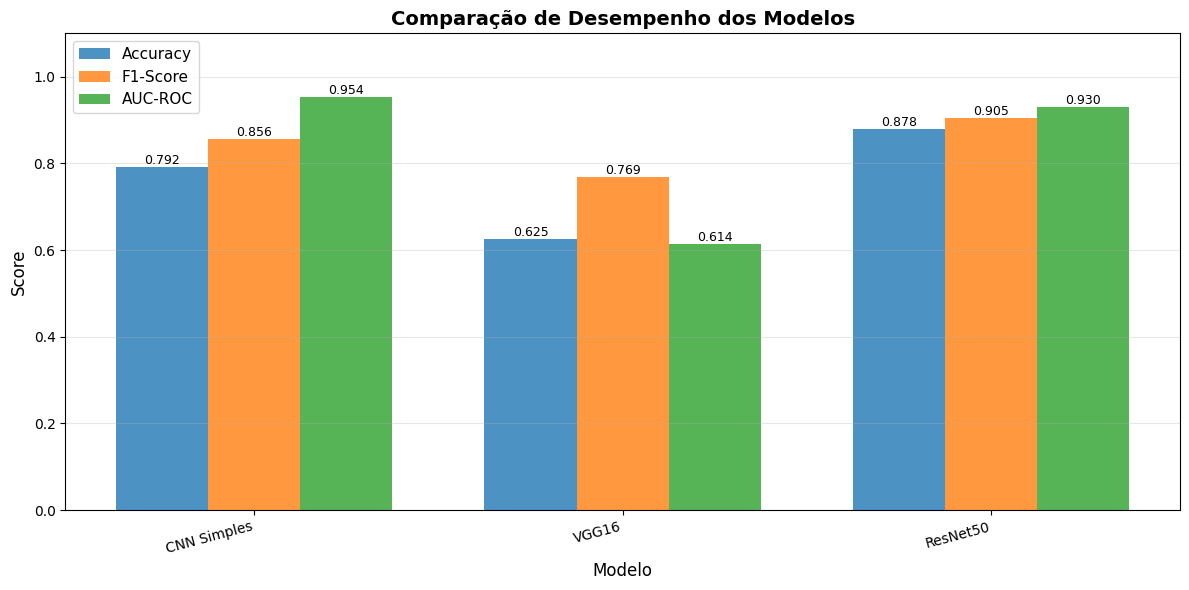


📊 Comparação de Modelos:
     Modelo  Accuracy  F1-Score  AUC-ROC
CNN Simples  0.791667  0.856195 0.953769
      VGG16  0.625000  0.769231 0.614092
   ResNet50  0.878205  0.904523 0.929641


In [29]:
# Compilar todos os resultados
all_results = {
    'CNN Simples': results_cnn,
    'VGG16': results_vgg16,
    'ResNet50': results_resnet50
}

# Comparar modelos
print("\n🏆 COMPARAÇÃO DE TODOS OS MODELOS\n")
compare_models_results(all_results)

## 🎯 Análise Detalhada dos Resultados

In [30]:
# Criar tabela comparativa completa
comparison_data = []

for model_name, results in all_results.items():
    from sklearn.metrics import precision_score, recall_score
    
    precision = precision_score(results['y_true'], results['predictions'])
    recall = recall_score(results['y_true'], results['predictions'])
    
    comparison_data.append({
        'Modelo': model_name,
        'Accuracy': f"{results['accuracy']*100:.2f}%",
        'Precision': f"{precision*100:.2f}%",
        'Recall': f"{recall*100:.2f}%",
        'F1-Score': f"{results['f1_score']*100:.2f}%",
        'AUC-ROC': f"{results['auc']:.4f}"
    })

df_comparison = pd.DataFrame(comparison_data)

print("\n📊 TABELA COMPARATIVA DETALHADA")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)


📊 TABELA COMPARATIVA DETALHADA
     Modelo Accuracy Precision  Recall F1-Score AUC-ROC
CNN Simples   79.17%    75.29%  99.23%   85.62%  0.9538
      VGG16   62.50%    62.50% 100.00%   76.92%  0.6141
   ResNet50   87.82%    88.67%  92.31%   90.45%  0.9296


## 🔍 Interpretação e Recomendações

In [31]:
# Encontrar melhor modelo por métrica
best_accuracy = max(all_results.items(), key=lambda x: x[1]['accuracy'])
best_f1 = max(all_results.items(), key=lambda x: x[1]['f1_score'])
best_auc = max(all_results.items(), key=lambda x: x[1]['auc'])

print("\n🏆 MELHORES MODELOS POR MÉTRICA:")
print("="*70)
print(f"🎯 Melhor Accuracy:  {best_accuracy[0]} ({best_accuracy[1]['accuracy']*100:.2f}%)")
print(f"🎯 Melhor F1-Score:  {best_f1[0]} ({best_f1[1]['f1_score']:.4f})")
print(f"🎯 Melhor AUC-ROC:   {best_auc[0]} ({best_auc[1]['auc']:.4f})")
print("="*70)

print("\n💡 INTERPRETAÇÃO:")
print("="*70)
print("""
1. ACCURACY (Acurácia):
   - Percentual de acertos geral
   - Pode ser enganosa em datasets desbalanceados
   
2. PRECISION (Precisão):
   - Dos casos que previmos como PNEUMONIA, quantos realmente são?
   - Importante para evitar falsos alarmes
   
3. RECALL (Sensibilidade):
   - Dos casos reais de PNEUMONIA, quantos conseguimos detectar?
   - CRÍTICO em medicina! Não podemos perder casos reais
   
4. F1-SCORE:
   - Média harmônica entre Precision e Recall
   - Boa métrica quando há desbalanceamento
   
5. AUC-ROC:
   - Capacidade do modelo de discriminar entre classes
   - Quanto mais próximo de 1, melhor
""")
print("="*70)

print("\n⚠️ CONSIDERAÇÕES MÉDICAS:")
print("="*70)
print("""
Em aplicações médicas, o RECALL (Sensibilidade) é geralmente mais importante
que a Precision. É melhor ter alguns falsos positivos (dizer que tem pneumonia
quando não tem) do que falsos negativos (não detectar uma pneumonia real).

Um paciente com falso positivo fará exames adicionais e descobrirá que está
bem. Mas um falso negativo pode deixar uma doença sem tratamento.

Por isso, na prática:
- Priorize modelos com ALTO RECALL
- O médico sempre deve ter a palavra final no diagnóstico
- Este sistema é uma ferramenta de APOIO, não substitui o profissional
""")
print("="*70)


🏆 MELHORES MODELOS POR MÉTRICA:
🎯 Melhor Accuracy:  ResNet50 (87.82%)
🎯 Melhor F1-Score:  ResNet50 (0.9045)
🎯 Melhor AUC-ROC:   CNN Simples (0.9538)

💡 INTERPRETAÇÃO:

1. ACCURACY (Acurácia):
   - Percentual de acertos geral
   - Pode ser enganosa em datasets desbalanceados
   
2. PRECISION (Precisão):
   - Dos casos que previmos como PNEUMONIA, quantos realmente são?
   - Importante para evitar falsos alarmes
   
3. RECALL (Sensibilidade):
   - Dos casos reais de PNEUMONIA, quantos conseguimos detectar?
   - CRÍTICO em medicina! Não podemos perder casos reais
   
4. F1-SCORE:
   - Média harmônica entre Precision e Recall
   - Boa métrica quando há desbalanceamento
   
5. AUC-ROC:
   - Capacidade do modelo de discriminar entre classes
   - Quanto mais próximo de 1, melhor


⚠️ CONSIDERAÇÕES MÉDICAS:

Em aplicações médicas, o RECALL (Sensibilidade) é geralmente mais importante
que a Precision. É melhor ter alguns falsos positivos (dizer que tem pneumonia
quando não tem) do que falsos n

## 💾 Salvar Resultados Finais

In [32]:
# Salvar tabela de comparação
csv_path = RESULTS_DIR / 'comparacao_modelos.csv'
df_comparison.to_csv(csv_path, index=False)
print(f"✅ Tabela de comparação salva em: {csv_path}")

# Salvar resumo dos melhores resultados
with open(RESULTS_DIR / 'resumo_resultados.txt', 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write("RESUMO DOS RESULTADOS - DETECÇÃO DE PNEUMONIA\n")
    f.write("="*70 + "\n\n")
    
    f.write("MODELOS TREINADOS:\n")
    f.write(f"1. CNN Simples (Baseline)\n")
    f.write(f"2. VGG16 Transfer Learning\n")
    f.write(f"3. ResNet50 Transfer Learning\n\n")
    
    f.write("="*70 + "\n")
    f.write("MELHORES MODELOS:\n")
    f.write("="*70 + "\n")
    f.write(f"Melhor Accuracy:  {best_accuracy[0]} ({best_accuracy[1]['accuracy']*100:.2f}%)\n")
    f.write(f"Melhor F1-Score:  {best_f1[0]} ({best_f1[1]['f1_score']:.4f})\n")
    f.write(f"Melhor AUC-ROC:   {best_auc[0]} ({best_auc[1]['auc']:.4f})\n")
    f.write("="*70 + "\n\n")
    
    f.write("COMPARAÇÃO COMPLETA:\n\n")
    f.write(df_comparison.to_string(index=False))
    f.write("\n\n" + "="*70 + "\n")

print(f"✅ Resumo salvo em: {RESULTS_DIR / 'resumo_resultados.txt'}")

print("\n" + "="*70)
print("🎉 TREINAMENTO E AVALIAÇÃO CONCLUÍDOS COM SUCESSO!")
print("="*70)
print(f"\n📁 Todos os resultados foram salvos em: {RESULTS_DIR}")
print(f"💾 Modelos salvos em: {MODELS_DIR}")
print(f"📊 Gráficos salvos em: {GRAFICOS_DIR}")

✅ Tabela de comparação salva em: ..\results\comparacao_modelos.csv
✅ Resumo salvo em: ..\results\resumo_resultados.txt

🎉 TREINAMENTO E AVALIAÇÃO CONCLUÍDOS COM SUCESSO!

📁 Todos os resultados foram salvos em: ..\results
💾 Modelos salvos em: ..\results\modelos
📊 Gráficos salvos em: ..\results\graficos

✅ Resumo salvo em: ..\results\resumo_resultados.txt

🎉 TREINAMENTO E AVALIAÇÃO CONCLUÍDOS COM SUCESSO!

📁 Todos os resultados foram salvos em: ..\results
💾 Modelos salvos em: ..\results\modelos
📊 Gráficos salvos em: ..\results\graficos


---
# ✅ Conclusão

Neste notebook, treinamos e avaliamos três modelos diferentes para detecção de pneumonia em raios-X:

1. **CNN Simples**: Modelo baseline criado do zero
2. **VGG16**: Transfer Learning com arquitetura clássica
3. **ResNet50**: Transfer Learning com arquitetura moderna

### 🎓 O que aprendemos:

- Como trabalhar com dados de imagens médicas
- Técnicas de data augmentation para aumentar o dataset
- Transfer Learning e como aproveitar modelos pré-treinados
- Métricas de avaliação apropriadas para problemas médicos
- Importância de balancear classes e interpretar erros

### 🚀 Próximos passos sugeridos:

- Testar outras arquiteturas (EfficientNet, DenseNet)
- Implementar Grad-CAM para visualizar o que o modelo está "olhando"
- Criar ensemble de modelos
- Ajustar hiperparâmetros com GridSearch/RandomSearch
- Deploy do modelo como API REST